In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import random
from argparse import ArgumentParser

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
from keras.backend.tensorflow_backend import set_session
import keras.backend as K
from scipy.interpolate import interpn
from neuron.plot import slices
import matplotlib.pyplot as plt

# project
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
model_name = 'autoencoder_3'
gpu_id = 1
iter_num = 135400

In [6]:
base_data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/'
val_vol_names = glob.glob(base_data_dir + 'validate/vols/*.npz')
random.shuffle(val_vol_names)  # shuffle volume list

# load atlas from provided files. This atlas is 160x192x224.
atlas = np.load('../data/atlas_norm.npz')
atlas_vol = atlas['vol'][np.newaxis,...,np.newaxis]


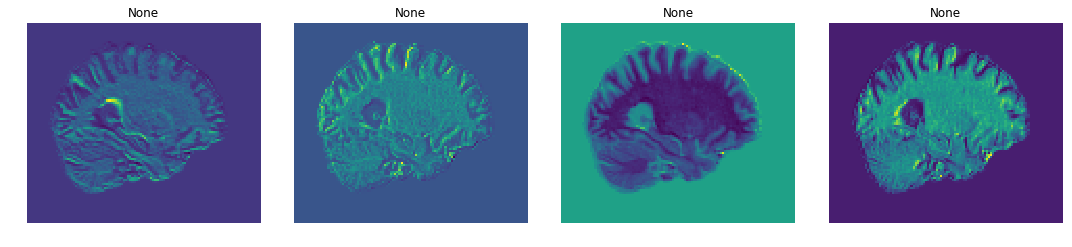

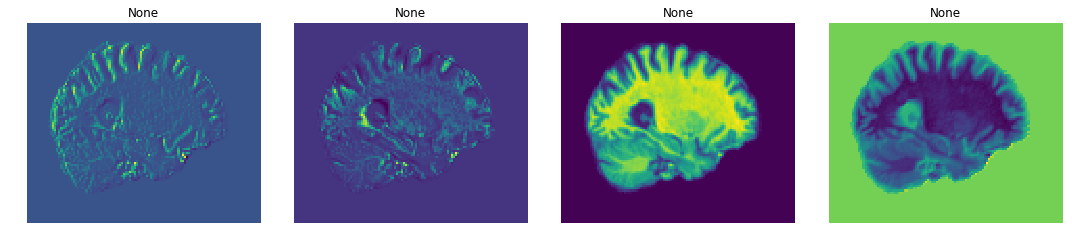

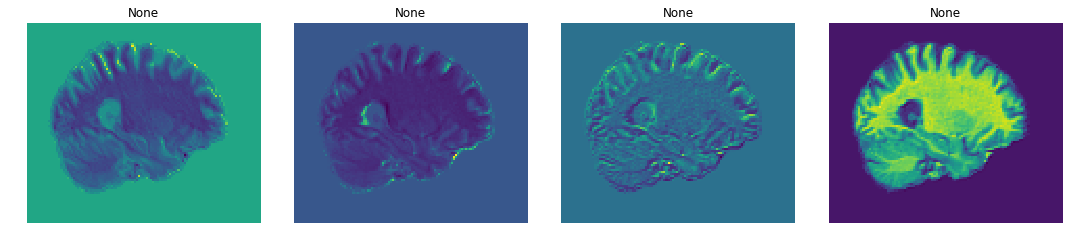

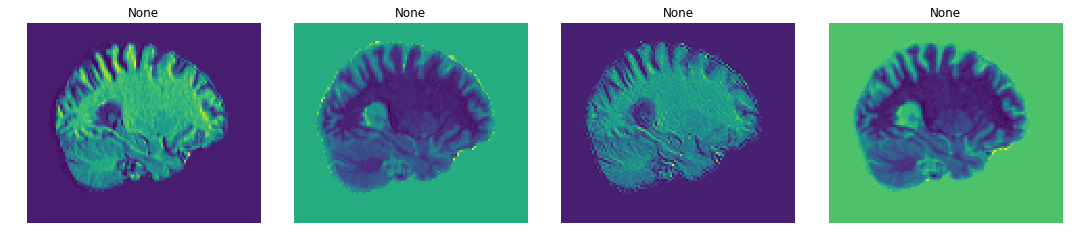

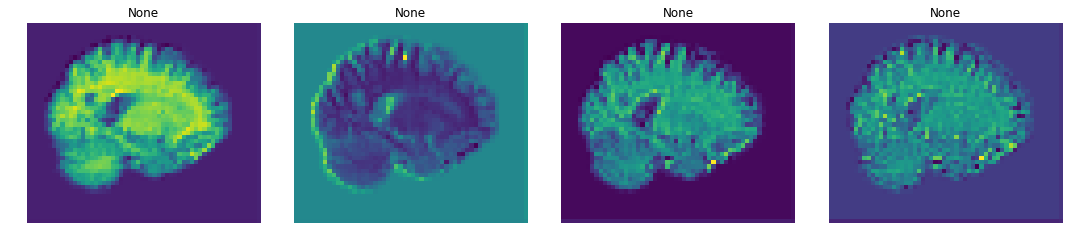

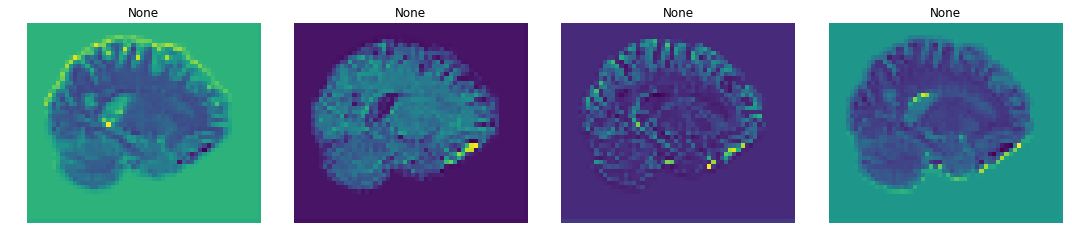

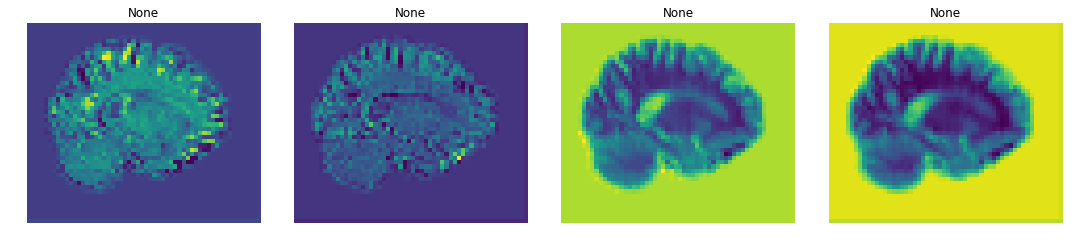

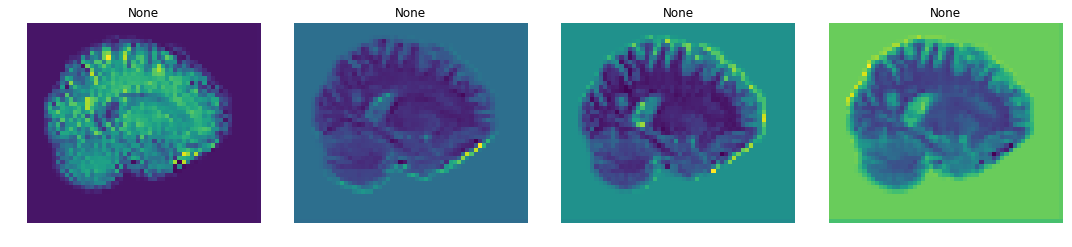

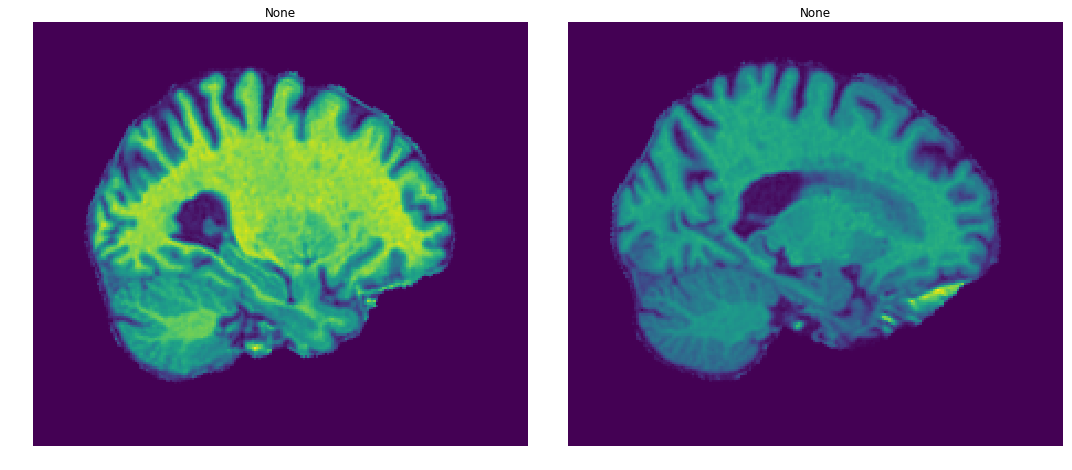

0.00026473114060013346


In [14]:
vol_size=(160,192,224)
nf_enc=[16,32,32]
nf_dec=[32,32,32,32,16,16]

# restrict_GPU_tf(str(gpu_id))
# restrict_GPU_keras(str(gpu_id))


"""
test

nf_enc and nf_dec
#nf_dec = [32,32,32,32,32,16,16,3]
# This needs to be changed. Ideally, we could just call load_model, and we wont have to
# specify the # of channels here, but the load_model is not working with the custom loss...
"""  

gpu = '/gpu:' + str(gpu_id)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

# load weights of model
with tf.device(gpu):
    full_model, train_model = networks.autoencoder(vol_size, nf_enc, nf_dec)
    full_model.load_weights('../models/' + model_name +
                     '/' + str(iter_num) + '.h5')

val_example_gen = datagenerators.example_gen(val_vol_names)

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
total_loss = 0
for step in range(1):

    # get data
    X = next(val_example_gen)[0]

    # get output
    enc = full_model.predict([X])

    output = enc[0]
    enc = enc[1:]
    
    loss = np.mean(np.square(output - X))
        
    total_loss += loss
    image = np.squeeze(output)
    slices([enc[0][0,25,:,:,i] for i in range(4)])
    slices([enc[0][0,25,:,:,i] for i in range(4,8)])
    slices([enc[0][0,25,:,:,i] for i in range(8,12)])
    slices([enc[0][0,25,:,:,i] for i in range(12,16)])

    slices([enc[1][0,25,:,:,i] for i in range(4)])
    slices([enc[1][0,25,:,:,i] for i in range(4,8)])
    slices([enc[1][0,25,:,:,i] for i in range(8,12)])
    slices([enc[1][0,25,:,:,i] for i in range(12,16)])
    
    original = np.squeeze(X)
    slices([original[50], original[100]])

print(total_loss)
